# 1. Selection of the dataset to build the profile HMM

In [1]:
import requests

In [2]:

pdb_query = '''{"query":{"type":"group","logical_operator":"and","nodes":[{"type":"group","logical_operator":"and","nodes":[{"type":"terminal","service":"text","parameters":{"attribute":"rcsb_polymer_entity_annotation.annotation_id","operator":"exact_match","negation":false,"value":"PF00014"}},{"type":"terminal","service":"text","parameters":{"attribute":"rcsb_polymer_entity_annotation.type","operator":"exact_match","value":"Pfam","negation":false}}],"label":"nested-attribute"},{"type":"terminal","service":"text","parameters":{"attribute":"rcsb_entry_info.diffrn_resolution_high.value","operator":"less_or_equal","negation":false,"value":3}},{"type":"terminal","service":"text","parameters":{"attribute":"entity_poly.rcsb_sample_sequence_length","operator":"range","negation":false,"value":{"from":50,"to":80,"include_lower":true,"include_upper":true}}},{"type":"terminal","service":"text","parameters":{"attribute":"entity_poly.rcsb_mutation_count","operator":"equals","negation":false,"value":0}}],"label":"text"},"return_type":"polymer_entity","request_options":{"group_by_return_type":"representatives","group_by":{"aggregation_method":"sequence_identity","ranking_criteria_type":{"sort_by":"rcsb_entry_info.resolution_combined","direction":"asc"},"similarity_cutoff":50},"paginate":{"start":0,"rows":25},"results_content_type":["experimental"],"sort":[{"sort_by":"score","direction":"desc"}],"scoring_strategy":"combined"}}'''
req = requests.get('http://search.rcsb.org/rcsbsearch/v2/query?json=%s' % requests.utils.requote_uri(pdb_query))
pdb_dict = req.json()

list_ids = []
for name in pdb_dict['result_set']:
    list_ids.append(name['identifier'])

with open('input_msa.txt', 'w') as input_msa:  # Input file for PDBeFold
    with open ('pdb_bpti.fasta', 'w') as pdb_btpi: # FASTA file with ID and sequence of retrieved proteins
        for protein_id in list_ids:
            entry_id, chain_id= protein_id.split("_")
            req2= requests.get('https://data.rcsb.org/rest/v1/core/polymer_entity/%s/%s' %(entry_id,chain_id))
            data = req2.json()
            sequence = data['entity_poly']['pdbx_seq_one_letter_code']
            chain=data['rcsb_polymer_entity_container_identifiers']['auth_asym_ids'][0]
            input_msa.write(entry_id + ':' + chain + '\n')
            pdb_btpi.write ('>' + entry_id + '_' + chain + '\n' + sequence + '\n')

# 2. Multiple Sequence Alignment

The MSA retrieved from the multiple structural alignment performed with PDBeFold, is saved in the 'kunitz_3d.aln' file.

In [3]:
# Parse kunitz_3d.aln file to generate a proper input file for HMMER build

with open('kunitz_3d.aln') as aln:
    with open('clean_kunitz_3d.aln', 'w') as aln2:
            for line in aln:
                line = line.strip()
                if line.startswith('>'):
                    sections = line.split()
                    aln2.write('\n'+sections[0]+'\n')
                else:
                    aln2.write(line.upper()) # write the whole sequence on the same line
        
with open('clean_kunitz_3d.aln', 'r') as clean_aln:               
    with open('cut_kunitz_3d.aln', 'w') as cut_aln:
        for line in clean_aln:
            line = line.strip()
            if line == '\n': 
                continue
            elif line.startswith('>'):
                cut_aln.write('\n'+line+'\n')
            else:
                cut_aln.write(line[19:79]) #select the positions containing the domain


# 3. Building of the profile HMM

In [2]:
import pyhmmer

In [3]:
#hmmer build: build the HMM
#generation of the alphabet object
alphabet = pyhmmer.easel.Alphabet.amino()

#loading the alignment and reading it in a digital format
with pyhmmer.easel.MSAFile("cut_kunitz_3d.aln", digital=True, alphabet=alphabet) as msa_file:
    msa = msa_file.read()

msa.name = b"kunitz_protein_domain"
    
#initialize a builder and a background and build an HMM
builder = pyhmmer.plan7.Builder(alphabet)
background = pyhmmer.plan7.Background(alphabet)
hmm, _, _ = builder.build_msa(msa, background)

#saving the resulting HMM
with open("kunitz_3d.hmm", "wb") as output_file:
    hmm.write(output_file)

# 4. Definition of the positive and negative benchmark sets

In [4]:
import requests
import re
import subprocess
import random

### POSITIVE benchmark set

In [7]:
pos_url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=false&format=fasta&query=%28%28xref%3Apfam-PF00014%29+AND+%28reviewed%3Atrue%29%29'
pos_fastas = requests.get(pos_url).text
pos_bpti_fasta = re.split(r'\n(?=>)', pos_fastas) #list of fastas for each entry retrieved
#print(len(pos_bpti_fasta)) #391

with open('all_bpti.fasta', 'w') as pos_file:
    for fasta in pos_bpti_fasta:
        fields = fasta.split('\n')
        for line in fields:
            if line.startswith('>'):
                pos_file.write('\n'+line+'\n')
            else:
                pos_file.write(line)

#remove the first empty line from the file
with open('all_bpti.fasta', 'r') as pos_file:
    lines = pos_file.readlines()
with open('all_bpti.fasta', 'w') as right_pos:
    for line in lines:
        if line.strip() != '':
            right_pos.write(line)

##### Refinement of the positive benchmark set through BLAST

In [8]:
db_generation = 'makeblastdb -in pdb_bpti.fasta -dbtype prot'
blastp_search = "blastp -query all_bpti.fasta -db pdb_bpti.fasta -out all_bpti.blast -outfmt 7"
subprocess.run(db_generation, shell=True, check=True)
subprocess.run(blastp_search, shell=True, check=True) 

remove_ids = []
with open('all_bpti.blast', 'r') as positives:
    for line in positives:
        if line.startswith('#'): 
            continue
        else:
            sections = line.strip().split('\t')
            acc_ver = sections[0].split('|')[1]
            perc_identity = float(sections[2])
            aln_length = int(sections[3])
            if perc_identity > 95 and aln_length > 50:
                remove_ids.append(acc_ver)

rem_uniq_ids = list(set(remove_ids)) #list of ids to be removed 
#print(len(rem_uniq_ids)) #33

with open('all_bpti.fasta', 'r') as all_bpti:
    with open('all_selected_pos.fasta', 'w') as all_selected: #final file with ids and sequences of selected positive proteins for kunitz domain
        selected = all_bpti.readlines()
        for line in range(len(selected)):
            if '>' in selected[line]:
                id = selected[line].split('|')[1]
                if id not in rem_uniq_ids:
                    all_selected.write(selected[line]+selected[line+1])



Building a new DB, current time: 05/17/2024 15:21:55
New DB name:   /Users/gaiagigante/Desktop/LB1/final_project/pdb_bpti.fasta
New DB title:  pdb_bpti.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/gaiagigante/Desktop/LB1/final_project/pdb_bpti.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 21 sequences in 0.0549879 seconds.




FASTA-Reader: Ignoring invalid residues at position(s): On line 6: 1, 5
FASTA-Reader: Ignoring invalid residues at position(s): On line 26: 1, 5


### NEGATIVE benchmark set

In [11]:
neg_url = 'https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28NOT+%28xref%3Apfam-PF00014%29+AND+%28reviewed%3Atrue%29%29'
neg_fastas = requests.get(neg_url).text
neg_bpti_fasta = re.split(r'\n(?=>)', neg_fastas) 
print(len(neg_bpti_fasta))

with open('all_non_bpti.fasta', 'w') as neg_file:
    for fasta in neg_bpti_fasta:
        fields = fasta.split('\n')
        for line in fields:
            if line.startswith('>'):
                neg_file.write('\n'+line+'\n')
            else:
                neg_file.write(line)

#remove the first empty line from the file
with open('all_non_bpti.fasta', 'r') as neg_file:
    lines = neg_file.readlines()
with open('all_non_bpti.fasta', 'w') as right_neg: #final file with ids and sequences of negative proteins for kunitz domain
    for line in lines:
        if line.strip() != '':
            right_neg.write(line) 

570891


##### Processing of the datasets before applying the HMM 

In [5]:
# Define the necessary functions to shuffle and split the datasets

def shuffle_fasta_file(filename):
    '''Takes a file, creates a list of id and sequence pairs and shuffles them'''
    with open(filename, 'r') as content:
        lines = content.readlines()
        pairs = []
        for pos in range(0, len(lines), 2):
            pairs.append((lines[pos], lines[pos+1]))
        random.shuffle(pairs)
        return pairs

def split_list_into_files (list_name, first_part, second_part):
    '''Takes a list and splits its content into two files'''
    split_point = int(len(list_name) / 2)
    first_half = list_name[:split_point]
    second_half = list_name[split_point:]
    with open(first_part, 'w') as part1:
        for tupla in first_half:
            for id_seq in tupla:
                if id_seq.endswith('\n'):
                    part1.write(id_seq)
                else:
                    part1.write(id_seq+'\n')
    with open(second_part, 'w') as part2:
        for tupla_2 in second_half:
            for id_seq_2 in tupla_2:
                if id_seq_2.endswith('\n'):
                    part2.write(id_seq_2)
                else:
                    part2.write(id_seq_2+'\n')

In [6]:
# Apply the functions to the positive dataset

pos_sequences = shuffle_fasta_file('all_selected_pos.fasta')
split_list_into_files(pos_sequences, 'pos1.fasta', 'pos2.fasta')

In [7]:
# Apply the functions to the negative dataset

neg_sequences = shuffle_fasta_file('all_non_bpti.fasta')
split_list_into_files(neg_sequences, 'neg1.fasta', 'neg2.fasta')

# 5. Apply the HMM to each subset

In [8]:
# First, define the functions needed to handle the hmmersearch output

def apply_hmm_to_sequence_db(hmm_out_file, db_file):    

    '''Takes in input the output of hmmerbuild and the database
    with sequences to which apply the hmm, and returns the found hits'''  

    with pyhmmer.plan7.HMMFile(hmm_out_file) as hmm_file:
        hmm = hmm_file.read()

    with pyhmmer.easel.SequenceFile(db_file, digital=True) as seq_file:
        sequences = seq_file.read_block()

    pipeline = pyhmmer.plan7.Pipeline(alphabet, Z=1, domZ=1, bias_filter=False, F1=1.0, F2=1.0, F3=1.0)
    hits = pipeline.search_hmm(hmm, sequences)
    return hits

def tabular_output_file(hits, filename):

    '''Takes in input the hits retrieved from hmmsearch 
    and creates a tabular format for the hits'''

    with open(filename, 'wb') as output_file:
        hits.write(output_file, format="targets", header=True)

def parse_pos_hits_file(input_file, output_file):

    '''Takes in input the tabular file with the hits and generates
    an output file with the format: hit_ID   E-value   1'''

    with open(input_file, 'r') as pos_hits_file:
        with open(output_file, 'w') as pos_parsed_file:
            for line in pos_hits_file:
                if line.startswith('#'):
                    continue
                line = line.strip()
                fields = line.split()
                id = fields[0].split('|')[1]
                e_value = fields[7]
                pos_label = '1'
                pos_parsed_file.write(id+' '+e_value+' '+pos_label+'\n')

def parse_neg_hits_file(input_hits_file, input_fasta_file, output_file):

    '''Takes in input the tabular file with the hits and generates
    an output file with the format: hit_ID   E-value   0'''

    tot_ids = set()
    with open(input_fasta_file, 'r') as neg_fasta:
        for line in neg_fasta:
            if line.startswith('>'):
                code = line.split('|')[1]
                tot_ids.add(code)
    hits_ids = set()
    with open(input_hits_file, 'r') as neg_hits_file:
        with open(output_file, 'w') as neg_parsed_file:
            for line in neg_hits_file:
                if line.startswith('#'):
                    continue
                line = line.strip()
                fields = line.split()
                id = fields[0].split('|')[1]
                hits_ids.add(id)
                e_value = fields[7]
                neg_label = '0'
                neg_parsed_file.write(id+' '+e_value+' '+neg_label+'\n')
                
            diff_ids = tot_ids - hits_ids
            for id2 in diff_ids:
                neg_parsed_file.write(id2+' '+'10'+' '+'0'+'\n')

def concatenate_files(file_1, file_2, output_file):
    '''Takes two input files and concatenates them'''
    with open(file_1, 'r') as file1:
        content_1 = file1.read()
    with open(file_2, 'r') as file2:
        content_2 = file2.read()
    with open(output_file, 'w') as output:
        output.write(content_1 + content_2)


##### Applying the functions to the 4 datasets

In [9]:
# pos1.fasta
hits_1 = apply_hmm_to_sequence_db('kunitz_3d.hmm', 'pos1.fasta')
tabular_output_file(hits_1, 'pos1.out')
parse_pos_hits_file('pos1.out', 'pos1.txt')

# pos2.fasta
hits_2 = apply_hmm_to_sequence_db('kunitz_3d.hmm', 'pos2.fasta')
tabular_output_file(hits_2, 'pos2.out')
parse_pos_hits_file('pos2.out', 'pos2.txt')

# neg1.fasta
hits_3 = apply_hmm_to_sequence_db('kunitz_3d.hmm', 'neg1.fasta')
tabular_output_file(hits_3, 'neg1.out')
parse_neg_hits_file('neg1.out', 'neg1.fasta', 'neg1.txt')

# neg2.fasta
hits_4 = apply_hmm_to_sequence_db('kunitz_3d.hmm', 'neg2.fasta')
tabular_output_file(hits_4, 'neg2.out')
parse_neg_hits_file('neg2.out', 'neg2.fasta', 'neg2.txt')

##### Concatenate the final .txt files (one with positive proteins and the other with negative ones) to obtain the final sets and finally merge them

In [10]:
concatenate_files('pos1.txt', 'neg1.txt', 'set1.txt')
concatenate_files('pos2.txt', 'neg2.txt', 'set2.txt')

#generate a unique set
concatenate_files('set1.txt', 'set2.txt', 'whole_set.txt')

# 6. Divide the whole dataset and perform the 2-folds cross validation

##### Divide the dataset in 70% (train set) and 30% (teste set) and then generate the 2 folds

In [7]:
def split_sets(set, ratio):

    '''Takes a file and a ratio and divides the elements 
    of the file based on the ratio. '''

    poss = []
    negs = []
    for el in set:
        if el[-2] == '1':
            poss.append(el)
        elif el[-2] == '0':
            negs.append(el)

    pos_index = int(len(poss) * ratio)
    neg_index = int(len(negs) * ratio)

    pos_train = poss[:pos_index]
    pos_test = poss[pos_index:]
    neg_train = negs[:neg_index]
    neg_test = negs[neg_index:]
    train = pos_train + neg_train
    test = pos_test + neg_test
    return train, test



In [8]:

with open('whole_set.txt', 'r') as set_file:
    set = set_file.readlines()

# Generate the trein set and test set
train, test = split_sets(set, 0.7)

# Generate the two folds 
fold_1, fold_2 = split_sets(train, 0.5)

In [9]:
# Count the number of positives and negatives in each set

# Train
poss = []
negs = []
for el in train:
        if el[-2] == '1':
            poss.append(el)
        elif el[-2] == '0':
            negs.append(el)
print( 'Train -> positives: ', len(poss), 'negatives: ', len(negs)) 

# Test
poss = []
negs = []
for el in test:
        if el[-2] == '1':
            poss.append(el)
        elif el[-2] == '0':
            negs.append(el)
print( 'Test -> positives: ', len(poss), 'negatives: ', len(negs)) 

# Fold 1
poss = []
negs = []
for el in fold_1:
        if el[-2] == '1':
            poss.append(el)
        elif el[-2] == '0':
            negs.append(el)
print( 'Fold 1 -> positives: ', len(poss), 'negatives: ', len(negs)) 

# Fold 2
poss = []
negs = []
for el in fold_2:
        if el[-2] == '1':
            poss.append(el)
        elif el[-2] == '0':
            negs.append(el)
print( 'Fold 2 -> positives: ', len(poss), 'negatives: ', len(negs)) 

Train -> positives:  250 negatives:  399623
Test -> positives:  108 negatives:  171268
Fold 1 -> positives:  125 negatives:  199811
Fold 2 -> positives:  125 negatives:  199812


##### Functions to evaluate the performances of the model

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from pandas.plotting import table
from matplotlib.font_manager import FontProperties

In [55]:
def get_data(predictions):

    '''Takes the file with the information about the HMM predictions
    and returns a list of lists, containing in each one the id of the 
    protein tested, its E-value and its label'''

    preds=[]
    for el in predictions:
        fields = el.rstrip().split()
        fields[1] = float(fields[1])
        fields[2] = int(fields[2])
        preds.append(fields)
    return preds


def get_confusion_matrix(preds, th=0.5):
    pred_lab = []
    true_lab = []
    false_neg = []
    false_pos = []
    for values in preds:  
        if values[1] <= th:
            pred_lab.append(1)
        else:
            pred_lab.append(0)
        true_lab.append(values[2])
    
    for pos in range(len(true_lab)):   #detect proteins that have been misclassified by the HMM (flase positives and false negatives)
        if pred_lab[pos] == 0 and true_lab[pos] == 1:
            false_neg.append(preds[pos])
        elif pred_lab[pos] == 1 and true_lab[pos] == 0:
            false_pos.append(preds[pos])

    cm = confusion_matrix(true_lab, pred_lab)
    cm = np.flipud(np.fliplr(cm))
    return cm, false_neg, false_pos

def get_performance_metrics(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = ((tp * tn) - (fp * fn)) / denominator if denominator != 0 else 0
    
    accuracy = (tp + tn) / np.sum(cm)
    true_pos_rate = tp / (tp + fn)
    false_pos_rate = fp / (fp + tn)
    
    return mcc, accuracy, true_pos_rate, false_pos_rate

##### Fold 1 -> training set, Fold 2 -> testing set

1e-07 1.0 [[   125      0]
 [     0 199811]]


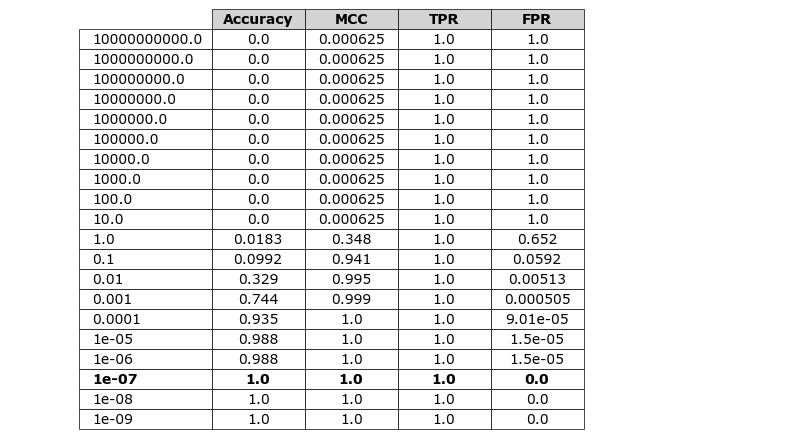

In [57]:
data_1 = get_data(fold_1)

thresholds = (10**-i for i in range(-10, 10))
best_performance_1 = float('-inf')
best_threshold_1 = None
df_1 = pd.DataFrame(columns = [ 'Accuracy', 'MCC', 'TPR', 'FPR'])

# Find the E-value that gives the best results on fold 1

for threshold in thresholds:
    cm_1, _, _ = get_confusion_matrix(data_1, threshold)
    accuracy_1, mcc_1, true_pos_rate_1, false_pos_rate_1 = get_performance_metrics(cm_1)
    df_1.loc[threshold] = [float(f'{accuracy_1:.3g}'), float(f'{mcc_1:.3g}'), 
                           float(f'{true_pos_rate_1:.3g}'), float(f'{false_pos_rate_1:.3g}')]

    if mcc_1 > best_performance_1:
        best_performance_1 = mcc_1
        best_threshold_1 = threshold

print(best_threshold_1, best_performance_1, cm_1)

df_1.index.name = 'E-value'
#df_1.title = 'Fold 1 performance metrics'
#df_1.to_csv('performances_train_fold_1.csv', sep='\t')

fig, ax = plt.subplots(figsize=(10, 5))  # Set size frame

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl = table(ax, df_1, loc='center', cellLoc='center', colWidths=[0.1] * len(df_1.columns))

# Style the table
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.2, 1.2)
font = FontProperties(family = 'Verdana')
for (i, j), cell in tbl.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)
    cell.set_text_props(fontproperties = font)
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize = 10)
        cell.set_facecolor('#D3D3D3')
    elif df_1.index[i-1] == best_threshold_1:
        cell.set_text_props(fontweight='bold')
# Save the table as an image
plt.savefig("table_1.png", bbox_inches='tight', dpi=300)
plt.show()

[[   125      0]
 [     2 199810]] 1e-07 0.992089772512336 0.9999899968490075 1.0 1.0009408844313654e-05


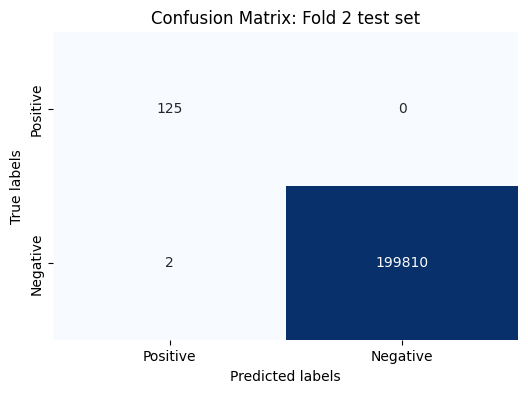

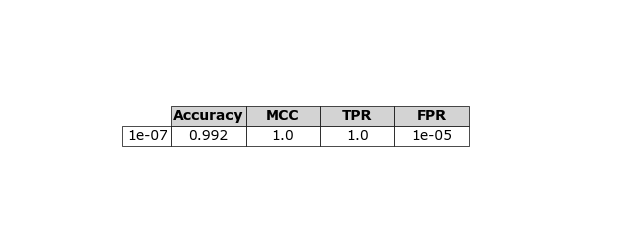

In [58]:
# Use the selected best thershold to measure the model performance on the second fold

data_2 = get_data(fold_2)
cm_test_1, _, _ = get_confusion_matrix(data_2, best_threshold_1)
accuracy_test_1, mcc_test_1, true_pos_rate_test_1, false_pos_rate_test_1 = get_performance_metrics(cm_test_1)
print(cm_test_1, best_threshold_1, accuracy_test_1, mcc_test_1, true_pos_rate_test_1, false_pos_rate_test_1)
df_test_fold_2 = pd.DataFrame(columns = ['Accuracy', 'MCC', 'TPR', 'FPR'])
df_test_fold_2.loc[best_threshold_1] = [float(f'{accuracy_test_1:.3g}'), float(f'{mcc_test_1:.3g}'), 
                           float(f'{true_pos_rate_test_1:.3g}'), float(f'{false_pos_rate_test_1:.3g}')]

# Plot the obtained results

plt.figure(figsize=(6, 4))
custom_annotations = [['TRUE POSITIVES', 'FALSE NEGATIVES'], ['FALSE POSITIVES', 'TRUE NEGATIVES']]
sns.heatmap(cm_test_1, annot=True, cmap='Blues', fmt='g', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], cbar = False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: Fold 2 test set')
plt.savefig('confusion_matrix_train_fold_2.png')
plt.show()


fig, ax = plt.subplots(figsize=(8, 3))  # Set size frame

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl_2 = table(ax, df_test_fold_2, loc='center', cellLoc='center', colWidths=[0.1] * len(df_test_fold_2.columns))

# Style the table
tbl_2.auto_set_font_size(False)
tbl_2.set_fontsize(8)
tbl_2.scale(1.2, 1.2)
font = FontProperties(family = 'Verdana')
for (i, j), cell in tbl_2.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)
    cell.set_text_props(fontproperties = font,)
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize = 10)
        cell.set_facecolor('#D3D3D3')

# Save the table as an image
plt.savefig("table_test_fold_2.png", bbox_inches='tight', dpi=300)
plt.show()

##### Use the fold 2 to find the best E-value and use it in the fold 1

1e-08 0.9999949984245037 [[   124      1]
 [     0 199812]]


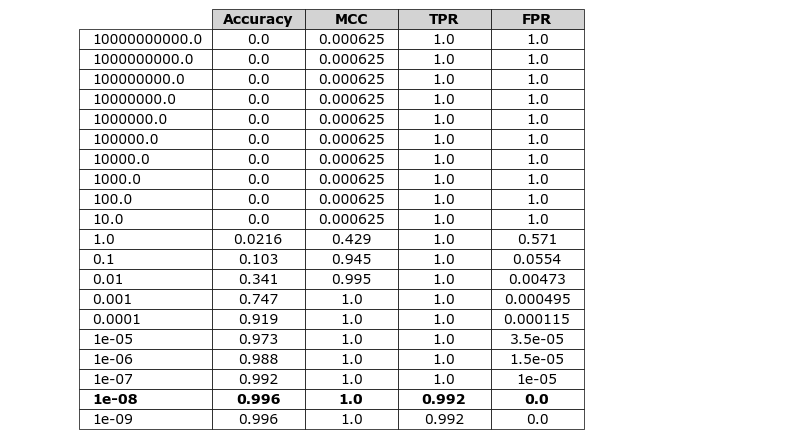

In [59]:
thresholds = (10**-i for i in range(-10, 10))
best_performance_2 = float('-inf')
best_threshold_2 = None

df_2 = pd.DataFrame(columns = ['Accuracy', 'MCC', 'TPR', 'FPR'])

#Find the E-value that gives the best results on fold 2

for threshold in thresholds:
    cm_2, _, _ = get_confusion_matrix(data_2, threshold)
    accuracy_2, mcc_2, true_pos_rate_2, false_pos_rate_2 = get_performance_metrics(cm_2)
    df_2.loc[threshold] = [float(f'{accuracy_2:.3g}'), float(f'{mcc_2:.3g}'), 
                           float(f'{true_pos_rate_2:.3g}'), float(f'{false_pos_rate_2:.3g}')]

    if mcc_2 > best_performance_2:
        best_performance_2 = mcc_2
        best_threshold_2 = threshold

df_2.index.name = 'E-value'
df_2.title = 'Fold 2 performance metrics'
#df_2.to_csv('performances_train_fold_2.csv', sep='\t')

print(best_threshold_2, best_performance_2, cm_2, )

fig, ax = plt.subplots(figsize=(10, 5))  # Set size frame

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl_3 = table(ax, df_2, loc='center', cellLoc='center', colWidths=[0.1] * len(df_2.columns))

# Style the table
tbl_3.auto_set_font_size(False)
tbl_3.set_fontsize(8)
tbl_3.scale(1.2, 1.2)
font = FontProperties(family = 'Verdana')
for (i, j), cell in tbl_3.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)
    cell.set_text_props(fontproperties = font)
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize = 10)
        cell.set_facecolor('#D3D3D3')
    elif df_1.index[i-1] == best_threshold_2:
        cell.set_text_props(fontweight='bold')
# Save the table as an image
plt.savefig("table_3.png", bbox_inches='tight', dpi=300)
plt.show()

[[   125      0]
 [     0 199811]] 1e-08 1.0 1.0 1.0 0.0


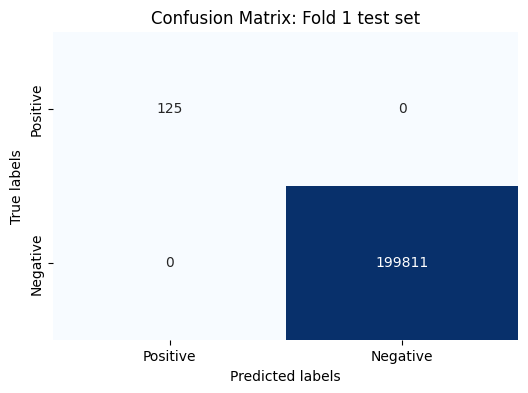

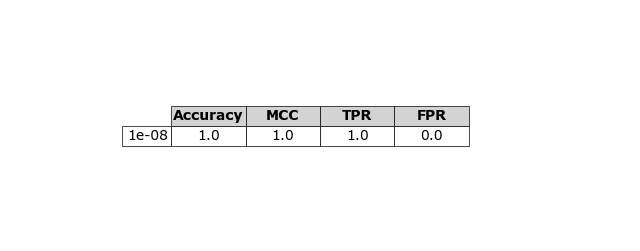

In [60]:
# Use the selected best thershold to measure the model performance on the first fold

cm_test_2, _, _ = get_confusion_matrix(data_1, best_threshold_2)
accuracy_test_2, mcc_test_2, true_pos_rate_test_2, false_pos_rate_test_2 = get_performance_metrics(cm_test_2)
print(cm_test_2, best_threshold_2, accuracy_test_2, mcc_test_2, true_pos_rate_test_2, false_pos_rate_test_2)

df_test_fold_1 = pd.DataFrame(columns = ['Accuracy', 'MCC', 'TPR', 'FPR'])
df_test_fold_1.loc[best_threshold_2] = [float(f'{accuracy_test_2:.3g}'), float(f'{mcc_test_2:.3g}'), 
                           float(f'{true_pos_rate_test_2:.3g}'), float(f'{false_pos_rate_test_2:.3g}')]


plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_2, annot=True, cmap='Blues', fmt='g', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: Fold 1 test set')
plt.savefig('confusion_matrix_fold_1_test.png')
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))  # Set size frame

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl_4 = table(ax, df_test_fold_1, loc='center', cellLoc='center', colWidths=[0.1] * len(df_test_fold_1.columns))

# Style the table
tbl_4.auto_set_font_size(False)
tbl_4.set_fontsize(8)
tbl_4.scale(1.2, 1.2)
font = FontProperties(family = 'Verdana')
for (i, j), cell in tbl_4.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)
    cell.set_text_props(fontproperties = font,)
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize = 10)
        cell.set_facecolor('#D3D3D3')

# Save the table as an image
plt.savefig("table_test_fold_1.png", bbox_inches='tight', dpi=300)
plt.show()

##### Make the average between the two selected E-values and use that value to test the generalization of the model through the test set

1.05e-07
[[   107      1]
 [     0 171268]] 0.9953566978903374 0.999994164877229 0.9907407407407407 0.0 [['D3GGZ8', 9.2e-07, 1]]


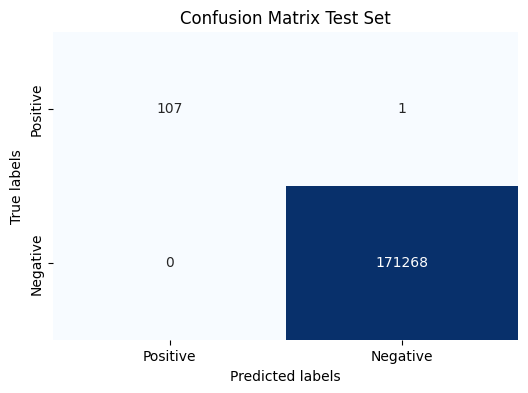

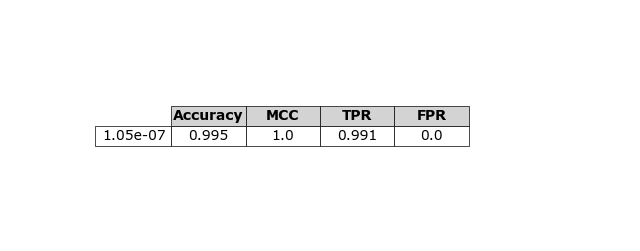

In [61]:
average_E_value = best_threshold_1 + best_threshold_2 / 2
print(average_E_value)

test_set_data = get_data(test)
cm_test_set, false_neg_test_set, false_pos_test_set = get_confusion_matrix(test_set_data, average_E_value)
acc_test_set, mcc_test_set, true_pos_test_set, false_pos_rate_test_set = get_performance_metrics(cm_test_set)
print(cm_test_set, acc_test_set, mcc_test_set, true_pos_test_set, false_pos_rate_test_set, false_neg_test_set)

df_test_set = pd.DataFrame(columns = ['Accuracy', 'MCC', 'TPR', 'FPR'])
df_test_set.loc[average_E_value] = [float(f'{acc_test_set:.3g}'), float(f'{mcc_test_set:.3g}'), 
                           float(f'{true_pos_test_set:.3g}'), float(f'{false_pos_rate_test_set:.3g}')]


plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_set, annot=True, cmap='Blues', fmt='g', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Set')
plt.savefig('confusion_matrix_test_set.png')
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))  # Set size frame

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl_5 = table(ax, df_test_set, loc='center', cellLoc='center', colWidths=[0.1] * len(df_test_set.columns))

# Style the table
tbl_5.auto_set_font_size(False)
tbl_5.set_fontsize(8)
tbl_5.scale(1.2, 1.2)
font = FontProperties(family = 'Verdana')
for (i, j), cell in tbl_5.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)
    cell.set_text_props(fontproperties = font,)
    if i == 0:
        cell.set_text_props(fontweight='bold', fontsize = 10)
        cell.set_facecolor('#D3D3D3')

# Save the table as an image
plt.savefig("table_test_set.png", bbox_inches='tight', dpi=300)
plt.show()


0.9953703703703703


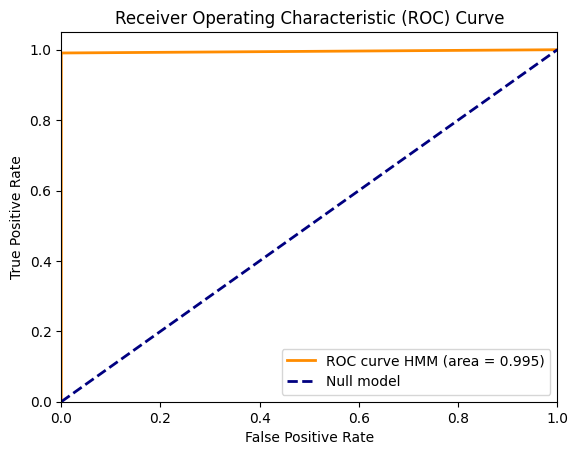

In [53]:
real_labels_test = []
predict_labels_test = []
for ex in test_set_data:
    real_labels_test.append(ex[2])
    if ex[1] <= average_E_value:
        predict_labels_test.append(1)
    else:
        predict_labels_test.append(0)

false_pos_rate_ROC, true_pos_rate_ROC, _ = roc_curve(real_labels_test, predict_labels_test)
roc_auc = auc(false_pos_rate_ROC, true_pos_rate_ROC)
print(roc_auc)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(false_pos_rate_ROC, true_pos_rate_ROC, color='darkorange', lw=lw, label=f'ROC curve HMM (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label = 'Null model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.png')
plt.show()